In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from sklearn.model_selection import  train_test_split
import pathlib
from Constants import *

In [2]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = BATCH_SIZE
)

Found 4857 files belonging to 4 classes.


In [3]:
test_dataset = keras.preprocessing.image_dataset_from_directory(
    VALIDATION_PATH,
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = BATCH_SIZE
)

Found 1311 files belonging to 4 classes.


In [4]:
class_names = test_dataset.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['glioma', 'meningioma', 'notumor', 'pituitary']
4


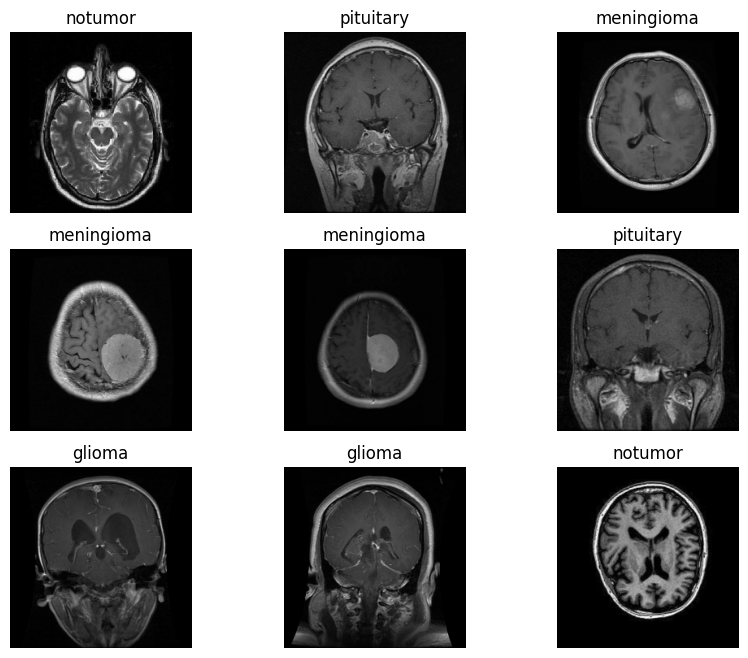

In [5]:
plt.figure(figsize = (10, 8))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
train_size = int(0.85 * len(train_dataset))
val_size = int(0.15 * len(train_dataset))
test_size = int(1 * len(test_dataset))

In [7]:
train_set = train_dataset.take(train_size)
val_set = train_dataset.skip(train_size)
test_set = test_dataset.take(test_size)

In [8]:
print(len(train_set),'\n',len(test_set),'\n',len(val_set))

258 
 82 
 46


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
resize_and_rescale = keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [11]:
augmented_data = keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape = (image_size, image_size,
                                     3)),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomFlip("horizontal_and_vertical")
])

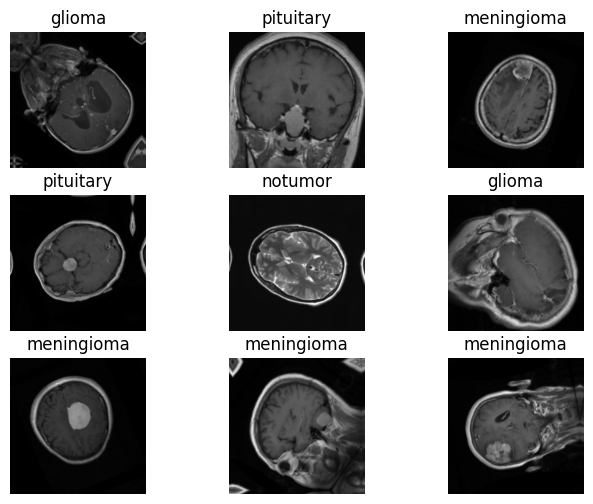

In [12]:
plt.figure(figsize = (8, 6))
for images, label in train_set.take(1):
    for i in range(9):
        augmented_images = augmented_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.title(class_names[label[i]])
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [14]:
os.environ["TFHUB_CACHE_DIR"] = "/tmp/model"
pre_trained_layer = hub.KerasLayer(path,
                                   input_shape = (image_size, image_size, 3),
                                   trainable = True)

pre_trained_layer

In [15]:
input_shape = (BATCH_SIZE, image_size, image_size, 3)

model = keras.Sequential([    
    pre_trained_layer,
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation = 'softmax'),    
])

model.build(input_shape = input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
 dense (Dense)               (None, 64)                64128     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3604653 (13.75 MB)
Trainable params: 3570541 (13.62 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [17]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [18]:
%%time

history = model.fit(train_set,
                    validation_data = val_set,
                    batch_size = BATCH_SIZE,
                    epochs = 15,
                    verbose = 1
                    )

Epoch 1/15
258/258 [==============================] - 746s 3s/step - loss: 0.6973 - accuracy: 0.8256 - val_loss: 0.3452 - val_accuracy: 0.9150
Epoch 2/15
258/258 [==============================] - 703s 3s/step - loss: 0.4907 - accuracy: 0.8871 - val_loss: 0.6742 - val_accuracy: 0.8779
Epoch 3/15
258/258 [==============================] - 700s 3s/step - loss: 0.4767 - accuracy: 0.8970 - val_loss: 0.6710 - val_accuracy: 0.8628
Epoch 4/15
258/258 [==============================] - 691s 3s/step - loss: 0.3781 - accuracy: 0.9264 - val_loss: 0.2972 - val_accuracy: 0.9465
Epoch 5/15
258/258 [==============================] - 702s 3s/step - loss: 0.3190 - accuracy: 0.9402 - val_loss: 0.4189 - val_accuracy: 0.9177
Epoch 6/15
258/258 [==============================] - 705s 3s/step - loss: 0.3424 - accuracy: 0.9414 - val_loss: 0.3650 - val_accuracy: 0.9259
Epoch 7/15
258/258 [==============================] - 694s 3s/step - loss: 0.3960 - accuracy: 0.9271 - val_loss: 0.4595 - val_accuracy: 0.9053

In [19]:
loss = model.evaluate(test_set)
loss

82/82 [==============================] - 41s 473ms/step - loss: 0.4063 - accuracy: 0.9481


[0.4062834680080414, 0.9481312036514282]

In [20]:
history = history.history

In [21]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

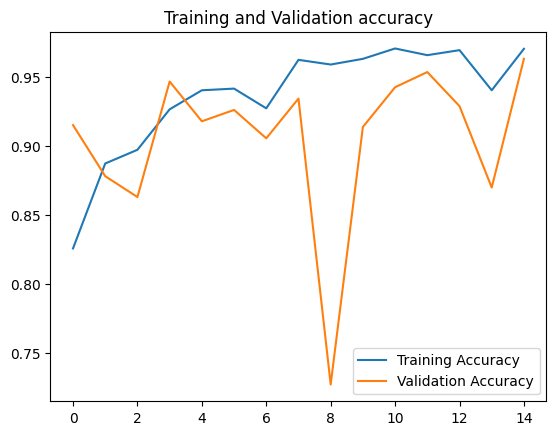

In [22]:
plt.plot(acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation accuracy")
plt.show()

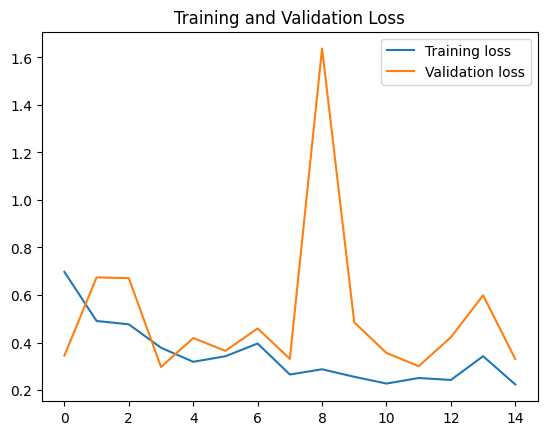

In [23]:
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [24]:
model_version = 1
model.save(f"../outputs/{model_version}")

# make changes to model architecture and save it by changing the model version number

INFO:tensorflow:Assets written to: ../outputs/1\assets


INFO:tensorflow:Assets written to: ../outputs/1\assets


In [25]:
model = tf.keras.models.load_model("../outputs/1")

Checking...
1/1 [==============================] - 2s 2s/step
Predicted label:  pituitary
Actual label: pituitary

Prediction matches!


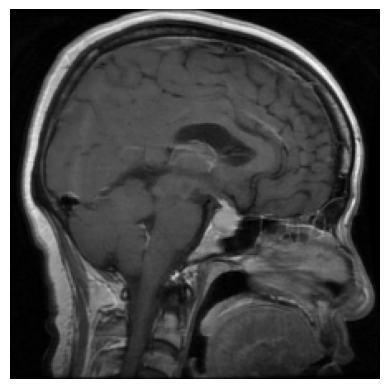

In [26]:
for images_batch, labels_batch in test_set.take(1):
    displayed_image = images_batch[0].numpy().astype("uint8")
    image_label = labels_batch[0].numpy()
    
    print("Checking...")
    plt.imshow(displayed_image)
    plt.axis("off")
    image_prediction = model.predict(images_batch)
    actual = class_names[np.argmax(image_prediction[0])]
    predicted = class_names[image_label]
    print("Predicted label: ", actual)
    print("Actual label:", predicted)
    
    if actual == predicted:
        print("\nPrediction matches!")
    else:
        print("\nWrong prediction!")

In [27]:
gt = "../data/testing_images/glioma"
mg = "../data/testing_images/meningioma"
nt = "../data/testing_images/notumor"
p = "../data/testing_images/pituitary"

g_t = os.listdir(gt)
m_g = os.listdir(mg)
n_t = os.listdir(nt)
p_t = os.listdir(p)

class_labels = ["glioma", "meningioma", "notumor", "pituitary"]

In [28]:
g_label = [0] * len(g_t)
m_label = [1] * len(m_g)
n_label = [2] * len(n_t)
p_label = [3] * len(p_t)

label = g_label + m_label + n_label + p_label

In [29]:
data = []

for img in g_t:
    image = Image.open("../data/testing_images/glioma/" + img).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    data.append(image)
    
for img in m_g:
    image = Image.open("../data/testing_images/meningioma/" + img).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    data.append(image)
    
for img in n_t:
    image = Image.open("../data/testing_images/notumor/" + img).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    data.append(image)
    
for img in p_t:
    image = Image.open("../data/testing_images/pituitary/" + img).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    data.append(image)

In [30]:
X = np.array(data)
y = np.array(label)

X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.001)

print(X_train.shape)
print(y_train.shape)

(854, 224, 224, 3)
(854,)


In [31]:
y_pred = model.predict(X_train)
y_pred_label = [np.argmax(i) for i in y_pred]

27/27 [==============================] - 25s 880ms/step


In [32]:
a = y_pred_label[:]
np.hstack(a)
b = y_train[:]
a == b

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [33]:
elem = 0
for x, y in zip(a, b):
    if x == y:
        elem += 1
print(f"Correctly predicted {elem} out of {len(a)} test images.")
print(f"{(elem / len(a)) * 100} %")

Correctly predicted 835 out of 854 test images.
97.7751756440281 %


Correctly predicted 58 out of 60 displayed test images,
2 incorrect predictions


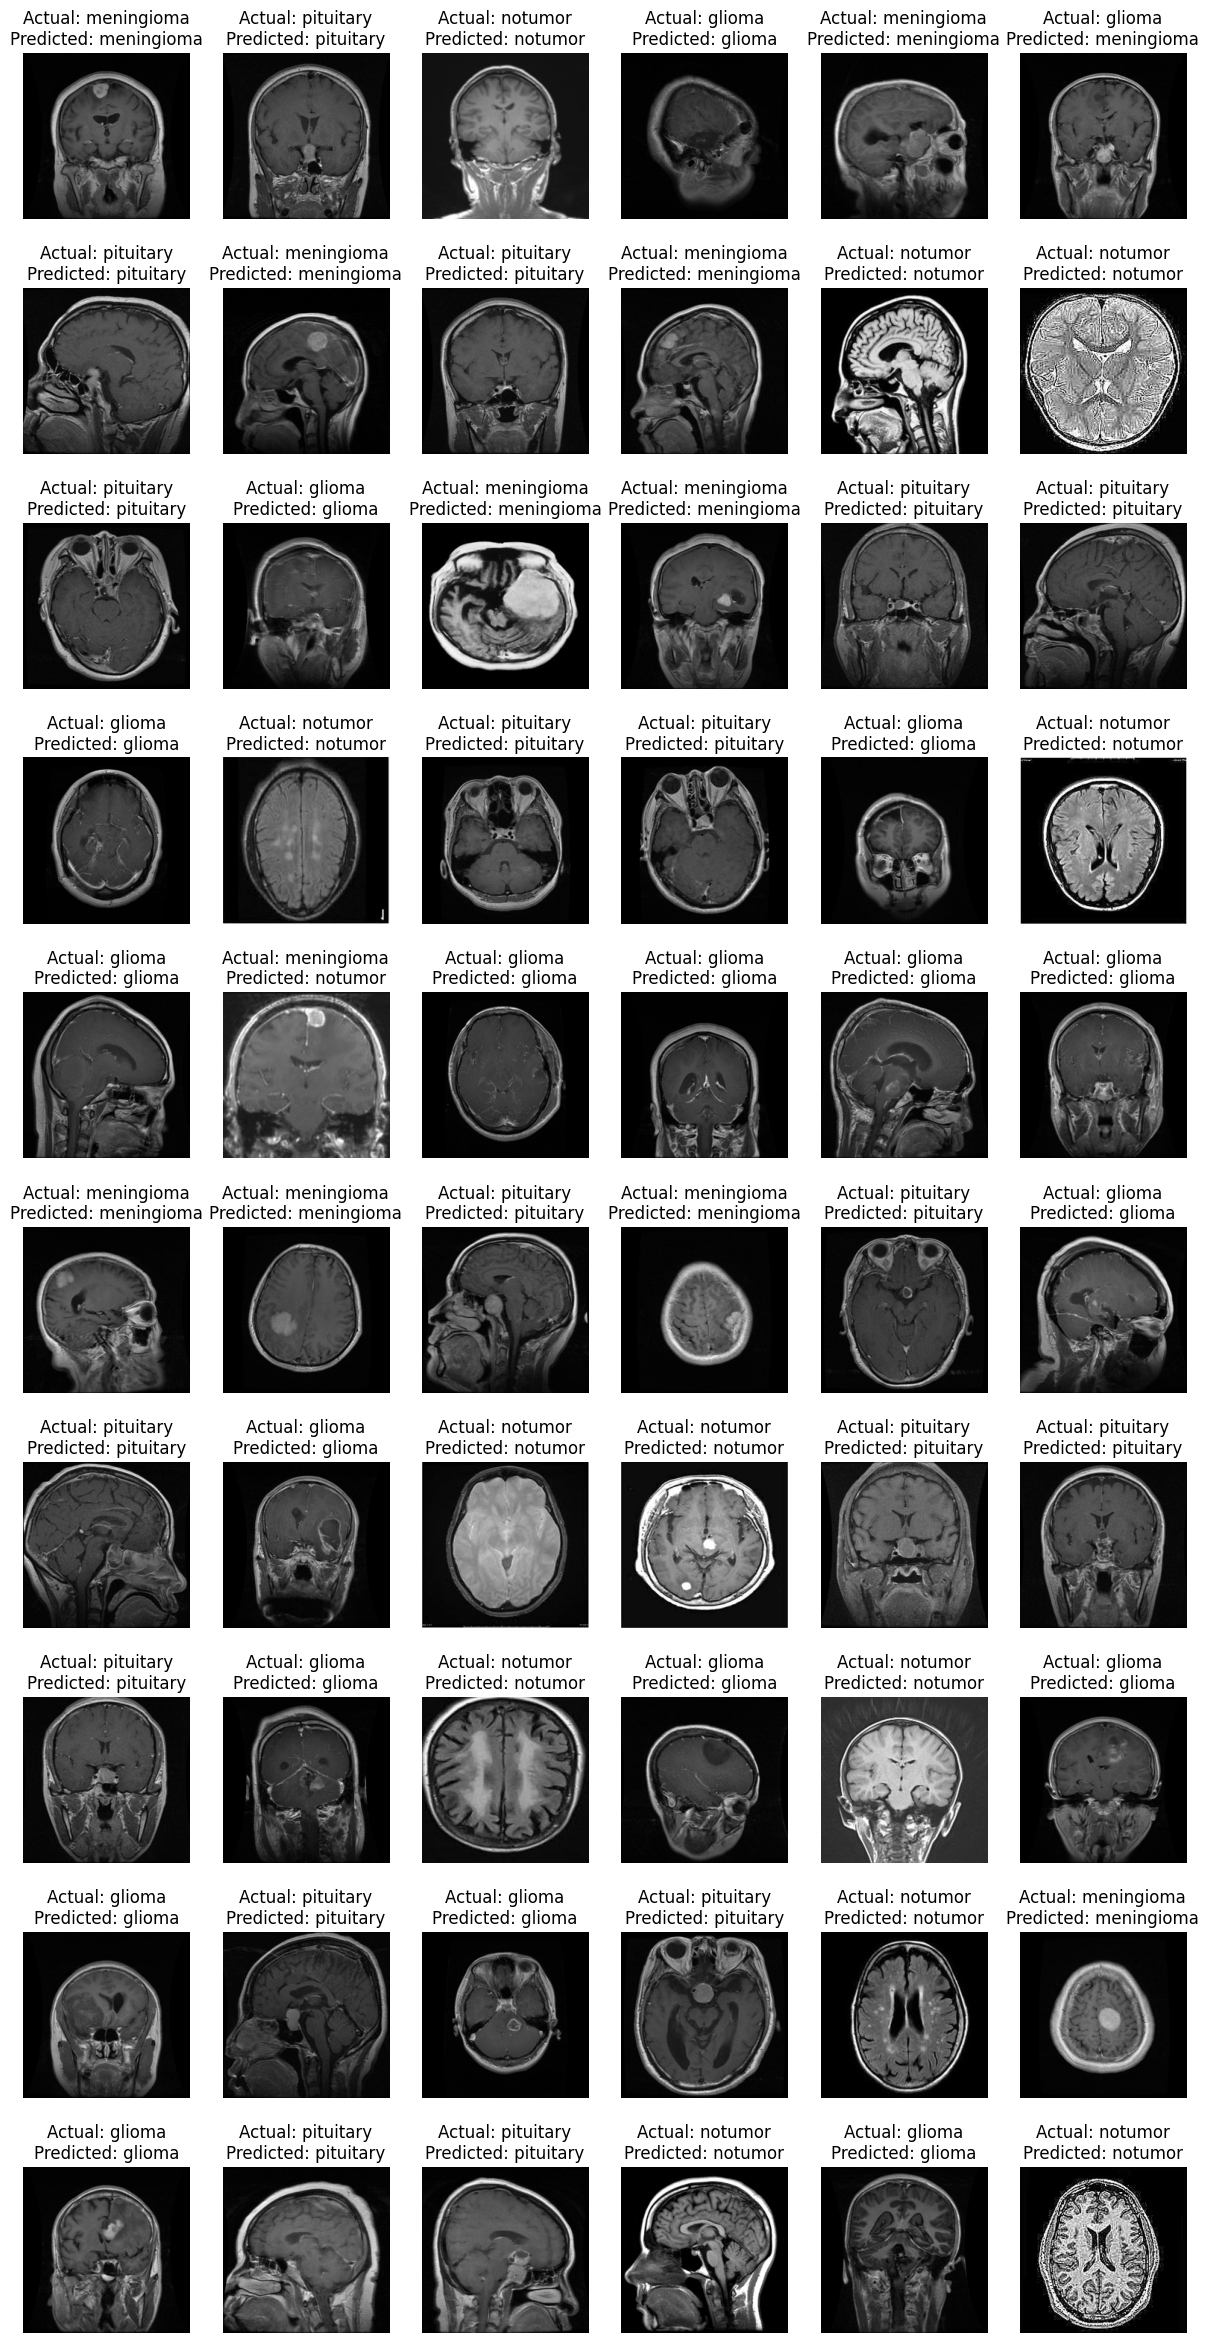

In [34]:
correct_count = 0
total = 60
incorrect_count = 0

plt.figure(figsize=(15, 30))
for i in range(0, total):
    plt.subplot(10, 6, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Actual: {class_labels[y_train[i]]}\nPredicted: {class_labels[y_pred_label[i]]}")
    plt.axis("off")
    if class_labels[y_train[i]] == class_labels[y_pred_label[i]]:
        correct_count += 1
    else:
        incorrect_count += 1
print(f"Correctly predicted {correct_count} out of {total} displayed test images,\n{incorrect_count} incorrect predictions")